In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [3]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [4]:
df = pd.read_csv("C:\Projects\I_am_learning\Dataset\IMDB_Dataset\IMDB_Dataset.csv")
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\shail\AppData\Local\Temp\ipykernel_18580\1726255006.py:1: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv("C:\Projects\I_am_learning\Dataset\IMDB_Dataset\IMDB_Dataset.csv")


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# Divide the data to training and testing data
X,y = df['review'].values, df['sentiment'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {X_train.shape}')
print(f'shape of test data is {X_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


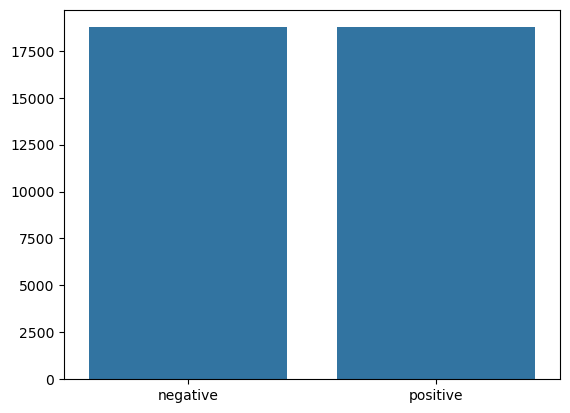

In [6]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

### Preprocessing the data
* preprocess_string is used to remove the punctuations, extra spaces and digits.
* Iteration over the training data is done.
    * Converting it to lowercase.
    * Removing stopwords like is,the,and
    * Word frequency using counter. 
    * Keeps only 1000 common words
    * creates one-hot encoding.
* Converts x_train and x_test to corresponding one-hot encoding. Filters out words 
* encoding labels

In [7]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    return s
def tokenize(x_train,y_train,x_val,y_val):
    word_list = []
    # Stop words contain is, the, and.etc
    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            # Remove all non-words characters
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
    # Counter includes word frequency in the context
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train,dtype=object), np.array(encoded_train,dtype=object),np.array(final_list_test,dtype=object), np.array(encoded_test,dtype=object),onehot_dict

In [21]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [22]:
X_train,y_train,X_test,y_test,vocab = tokenize(X_train,y_train,X_test,y_test)
print(f'Length of vocabulary is {len(vocab)}')

AttributeError: 'list' object has no attribute 'lower'

In [9]:
len(X_train[18])

49

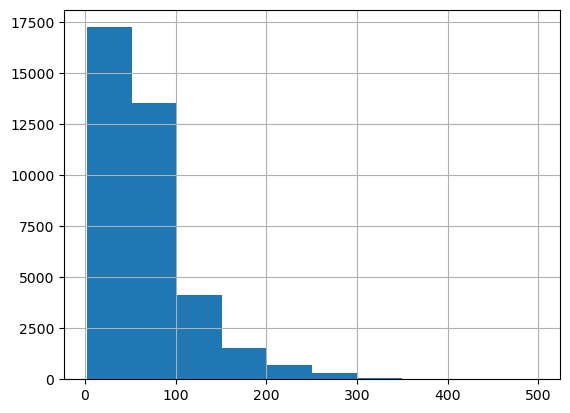

count    37500.000000
mean        69.318987
std         48.059684
min          2.000000
25%         39.000000
50%         54.000000
75%         85.000000
max        499.000000
dtype: float64

In [10]:
rev_len = [len(i) for i in X_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [11]:
# Add a padding and convert the dataset to tensor format
def padding_tensor(X,y,length):
    # features = np.zeros((len(X), length),dtype=int)
    # for ii, review in enumerate(X):
    #     if len(review) != 0:
    #         features[ii, -len(review):] = np.array(review)[:length]
    # data = TensorDataset(torch.from_numpy(features), torch.from_numpy(y))

    # Convert X to a padded numpy array (ensures fixed shape)
    X_padded = pad_sequences(X, maxlen=length, padding='post', truncating='post', dtype='int64')
    y = np.array(y, dtype=np.int64)

    # Convert to PyTorch tensors (ensuring correct dtype)
    features = torch.tensor(X_padded, dtype=torch.int64)
    labels = torch.tensor(y, dtype=torch.int64)

    # Create TensorDataset
    data = TensorDataset(features, labels)
    return data

In [12]:
Train_data = padding_tensor(X_train,y_train,500)
Test_data = padding_tensor(X_test,y_test,500)
# dataloaders
batch_size = 32

# make sure to SHUFFLE your data
train_loader = DataLoader(Train_data, shuffle=True, batch_size=batch_size,drop_last=True)
test_loader = DataLoader(Test_data, shuffle=True, batch_size=batch_size,drop_last=True)

In [13]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([32, 500])
Sample input: 
 tensor([[786, 231, 462,  ...,   0,   0,   0],
        [ 40,  10, 722,  ...,   0,   0,   0],
        [891,  88, 729,  ...,   0,   0,   0],
        ...,
        [ 39,   2,  43,  ...,   0,   0,   0],
        [  2,  31,  92,  ...,   0,   0,   0],
        [116, 172, 890,  ...,   0,   0,   0]])
Sample input: 
 tensor([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 1, 1, 1, 1, 0])


### LSTM Model
* Long short term memory helps the NN to store the informative context and forget the stuff which is not required.
* LSTM is type of Recurrent Neural Network. RNN iteratively runs through the model letter by letter by passing as input and the output is given as an input and checked with the data set to correct the error.
* The issue with RNN is Long term dependency problem. When more an more information is piled up with more time. RNN faces difficulty with training and understanding.
* LSTM rectifies the problem by adding the state module to the RNN. When the input to output is provided with RNN. The state information is also given as input.
* LSTM cell has three gate:
    * Forget gate: Forget gate enables the state where the information can be forgotten.
    * I/O gate: What new information can be added and updated to the information in an model. 
    * O/P gate: Based on the whole information, which part needs to be output of the cell.
    * it is b/w the range of 0 and 1. based on which the information is passed inside the gate. 0 meaning no information is passed.
    

Embedding layer: Maps word to numerical vectors, allowing model to learn contextual representations of words.
LSTM layer: processes sequential data (In our case it is sentences) and learns to capture long-term dependencies in the input sequence.
Dropout layer:  layer helps prevent overfitting by randomly dropping out neurons during training. Some of the output units to zero during training to prevent overfitting
FC linear layer: final output layer, where the model predicts the sentiment label (e.g., positive or negative). a learned weight matrix.
Sigmoid:  output of the linear layer to produce a probability score between 0 and 1.

In forward,
* We have a initial hidden state and input sequence as inputs. 
* initial we take the embedding.
* Embedding and hidden layer is given in input of LSTM. hidden state is like a "memory" cell that stores information about the input sequence up to that point.
* 

In [14]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,output_dim,embedded_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim =hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        self.embedding  = nn.Embedding(vocab_size,embedded_dim)

        self.lstm = nn.LSTM(input_size=embedded_dim,hidden_size=self.hidden_dim,num_layers=no_layers, batch_first=True,dropout=drop_prob)

        self.dropout = nn.Dropout(0.3)

        self.fc = nn.Linear(self.hidden_dim,output_dim)
        self.sig = nn.Sigmoid()
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out,(h_n, c_n) = self.lstm(embeds,hidden)
        lstm_out = lstm_out.contiguous().view(-1,self.hidden_dim)
        last_hidden_state = h_n[-1]
        # dropout and fully connected layer
        out = self.dropout(last_hidden_state)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        # return last sigmoid out
        return sig_out,(h_n, c_n)
    # Initially the hidden layer is zerio with hidden and state and cell state.
    # 
    def init_hidden(self, batch_size, device):
        ''' Initializes hidden state dynamically '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        return (torch.zeros((self.no_layers, batch_size, self.hidden_dim), device=device),
            torch.zeros((self.no_layers, batch_size, self.hidden_dim), device=device))
        



In [15]:
no_layers = 2
vocab_size = len(vocab) + 1
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,output_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)


SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [16]:
# loss and optimization functions
lr=0.0005

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred, label):
    pred = torch.round(pred.squeeze().detach())  # Detach from computation graph
    return torch.sum(pred == label.squeeze()).item()

clip = 5
epochs = 10
valid_loss_min = np.Inf
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]
for epoch in range(epochs):
    trainl_loss = []
    train_acc = 0.0
    model.train()
    #init the hidden state
   
    for inputs,labels in train_loader:
        batch_size = inputs.shape[0]
        h = model.init_hidden(batch_size,device)
        h = tuple([each.data for each in h])
        inputs,labels = inputs.to(device),labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        
        # Computes gradients of the loss with respect to model parameters (weights and biases).
        optimizer.zero_grad()
        output,h = model(inputs,h)
        loss = criterion(output.squeeze(),labels.float())
        # Computes gradients of the loss with respect to model parameters (weights and biases).
        trainl_loss.append(loss.item())
        accuracy = acc(output,labels)
        train_acc += accuracy
        loss.backward()
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        # Update weights and biases
        optimizer.step()

    
    vall_loss = []
    val_acc = 0.0
    model.eval()
    for inputs,labels in test_loader:
        batch_size = inputs.shape[0]
        val_h = model.init_hidden(batch_size,device)
        val_h = tuple([each.data for each in val_h])
        inputs, labels = inputs.to(device), labels.to(device)
        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())
        vall_loss.append(val_loss.item())
        accuracy = acc(output,labels)
        val_acc += accuracy
    epoch_train_loss = np.mean(trainl_loss)
    epoch_val_loss = np.mean(vall_loss)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(test_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        # torch.save(model.state_dict(), 'best_model.pth')  # Specify a filename
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.6937096950643394 val_loss : 0.693154047238521
train_accuracy : 49.87466666666667 val_accuracy : 49.912
Validation loss decreased (inf --> 0.693154).  Saving model ...
Epoch 2
train_loss : 0.6933172571669268 val_loss : 0.6931491972544255
train_accuracy : 49.858666666666664 val_accuracy : 49.888
Validation loss decreased (0.693154 --> 0.693149).  Saving model ...
Epoch 3
train_loss : 0.6932691637009866 val_loss : 0.6931524695494236
train_accuracy : 49.984 val_accuracy : 49.96
Epoch 4
train_loss : 0.6933270672974069 val_loss : 0.6931974906187791
train_accuracy : 49.781333333333336 val_accuracy : 49.936
Epoch 5
train_loss : 0.6932694819826636 val_loss : 0.6931620984505384
train_accuracy : 49.93333333333334 val_accuracy : 49.936
Epoch 6
train_loss : 0.6932350188417378 val_loss : 0.6931874100978558
train_accuracy : 50.013333333333335 val_accuracy : 49.928
Epoch 7
train_loss : 0.6932475379549673 val_loss : 0.693205979390022
train_accuracy : 50.064 val_accuracy : 49.896


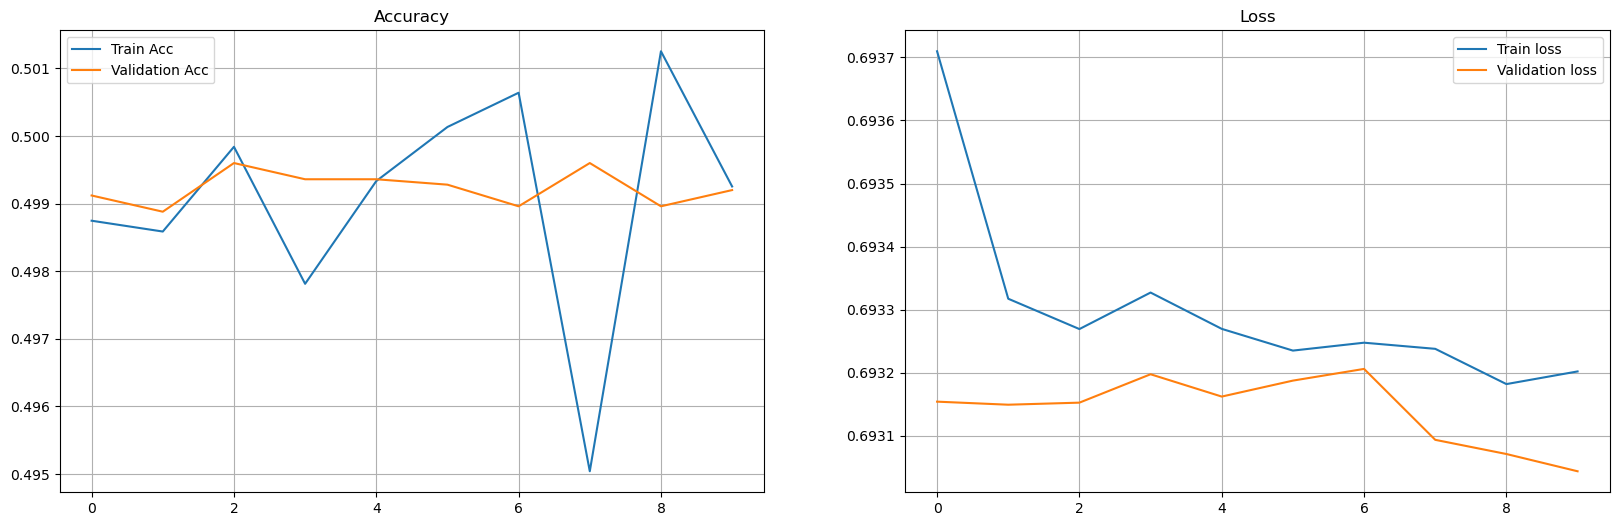

In [17]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()